# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including **Naïve Bayes**, **Logistic regression**, **K-nearest neighbor**, **decision trees and random forests**, **support vector machines** and even a simple **neural network, the perceptron**. We will also demonstrate **ensemble** techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
from sklearn import *
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp
import pandas as pd

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The **four data patterns** include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [2]:
noise = .2

# dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
# dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
# dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
# dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [3]:
dfTrain

,vect,category
873,"[-0.7694680355275987, -0.5700086804262213]",1
509,"[0.19391468615744262, 0.6714870016834139]",1
130,"[0.6260124282304551, -0.7654023936998176]",0
268,"[0.08316748405400298, -0.9561726643279944]",0
537,"[-0.11525647074799303, 0.9258390626681674]",1
516,"[-0.6759103651696556, 0.041336469326322234]",0
564,"[0.7098222540625168, -1.1927629775413096]",0
851,"[0.5600982517740313, -0.03075559703406744]",1
179,"[-0.03864660115442353, 0.16145610176130104]",1
425,"[0.041261044133413305, 0.4921016289313677]",1


So, dfTrain has two columns, vect and category. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


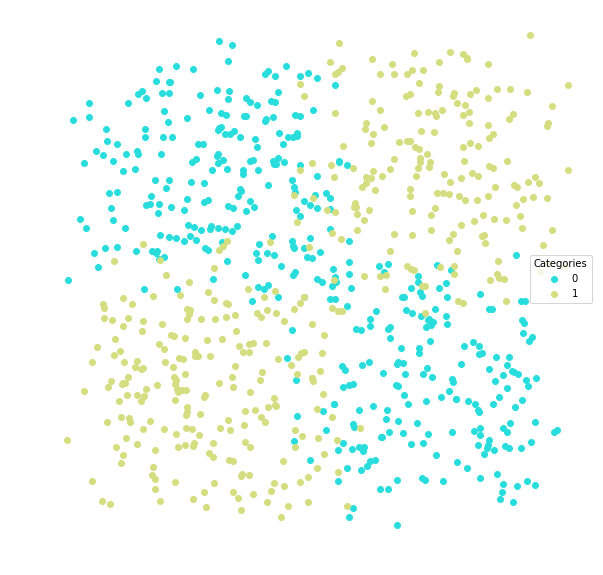

In [4]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [5]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using `sklearn` here. What is `sklearn`? It's an open source machine learning library for Python. We use `sklearn` because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [6]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_isotonic',
 'base',
 'calibration',
 'clone',
 'cluster',
 'compose',
 'config_context',
 'covariance',
 'cross_decomposition',
 'datasets',
 'decomposition',
 'discriminant_analysis',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'feature_selection',
 'gaussian_process',
 'get_config',
 'impute',
 'isotonic',
 'kernel_approximation',
 'kernel_ridge',
 'linear_model',
 'logger',
 'logging',
 'manifold',
 'metrics',
 'mixture',
 'model_selection',
 'multiclass',
 'multioutput',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'pipeline',
 'preprocessing',
 'random_projection',
 're',
 'semi_supervised',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils',
 'warnings']

Now we fit the model by giving it our training data

In [7]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

Here, `stack` function is used. Why did we use stack function here? 

**This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element.** 

Let's see what dfTrain['vect'] looks like:

In [8]:
dfTrain['vect']

873      [-0.7694680355275987, -0.5700086804262213]
509       [0.19391468615744262, 0.6714870016834139]
130       [0.6260124282304551, -0.7654023936998176]
268      [0.08316748405400298, -0.9561726643279944]
537      [-0.11525647074799303, 0.9258390626681674]
516     [-0.6759103651696556, 0.041336469326322234]
564       [0.7098222540625168, -1.1927629775413096]
851      [0.5600982517740313, -0.03075559703406744]
179     [-0.03864660115442353, 0.16145610176130104]
425      [0.041261044133413305, 0.4921016289313677]
533      [0.22424905611298845, 0.12389038427912355]
253       [-0.11833820444350499, 0.789090115488671]
945     [0.022249731917426074, 0.12527325183274735]
26        [0.1168004848209499, -0.9321104233678069]
656    [0.057420825083935284, -0.35385629858736545]
932       [0.6622312387254242, -0.7224342335634883]
811      [-0.46311146948296467, -0.290822810874524]
383       [0.36902218572858636, 0.2102816276619497]
197     [-0.35213455826237466, -1.2885326310793055]
305    [0.39

And let's see what np.stack(dfTrain['vect']) does:

In [9]:
# help(np.stack)
np.stack(dfTrain['vect'])

array([[-0.76946804, -0.57000868],
       [ 0.19391469,  0.671487  ],
       [ 0.62601243, -0.76540239],
       ...,
       [-0.29460963,  0.32044553],
       [ 0.12019132, -0.48645709],
       [-0.62904565,  0.14506235]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [10]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.11,0.889989,0.888889,0.845123,0.888889
1,0.11,0.889989,0.891089,0.849040,0.891089


This lets us look at which classes do better:

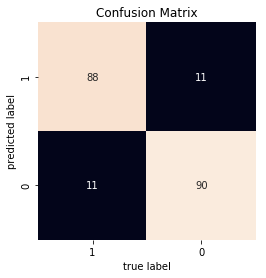

In [11]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

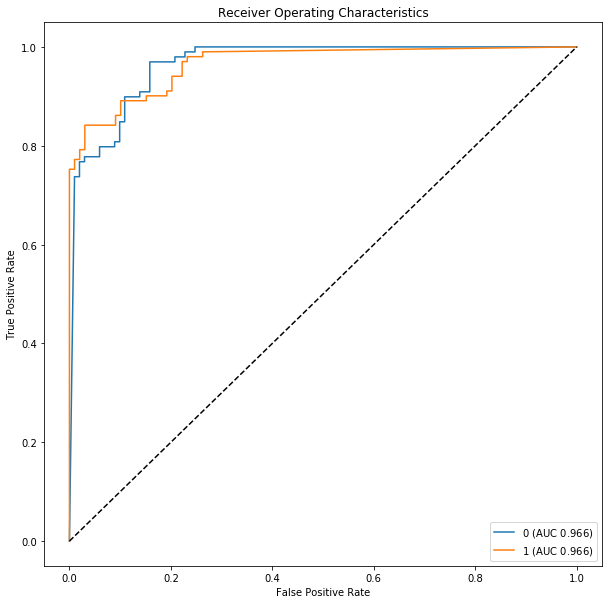

In [12]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


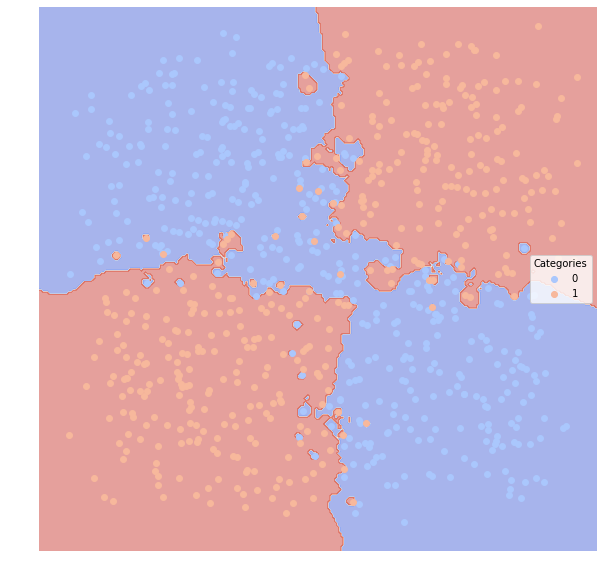

In [13]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [14]:
# dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
# dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
# dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
# dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Spam
Loading Ham
Converting to vectors


In [15]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [16]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [17]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.154971,0.831266,0.960938,0.943692,0.851211
spam,0.154971,0.831266,0.500000,0.434900,0.811321


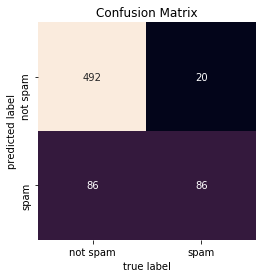

In [18]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

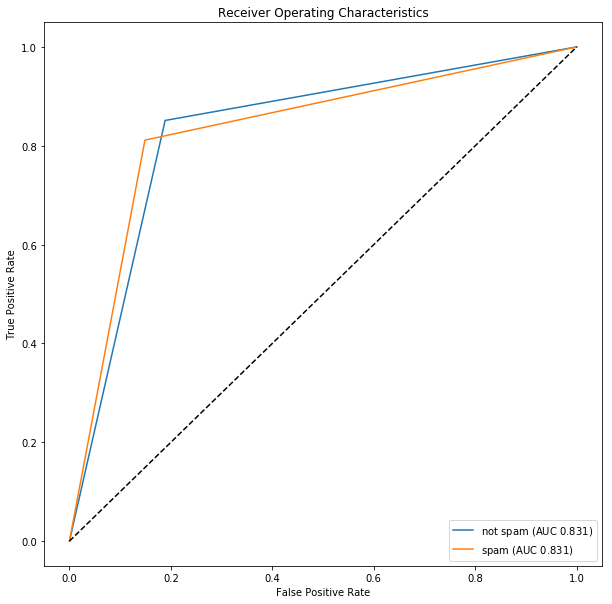

In [19]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


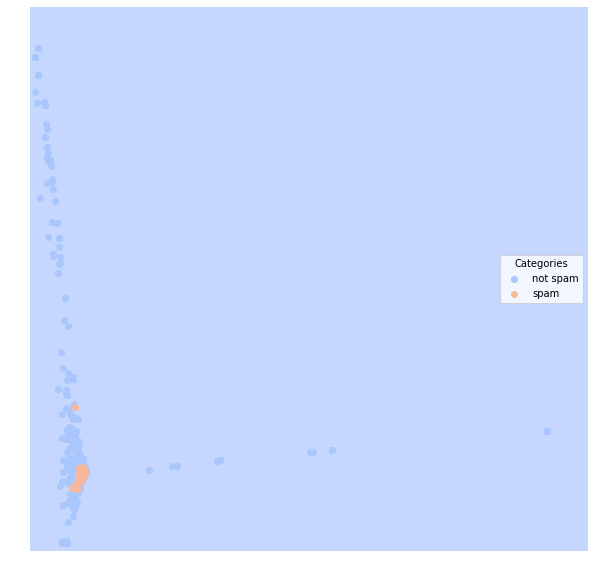

In [20]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which **artificially constructed data source** and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [21]:
# Generate ten distince artificial datasets and classify them with all the available methods
data_generator_dict = {
    "random": lucem_illud_2020.random,
    "andSplit": lucem_illud_2020.andSplit,
    "xorSplit": lucem_illud_2020.xorSplit,
    "targetSplit": lucem_illud_2020.targetSplit,
    "multiBlobs": lucem_illud_2020.multiBlobs
}

method_dict = {
    "Bayes": sklearn.naive_bayes.GaussianNB(),
    "svm_linear": sklearn.svm.SVC(kernel="linear", probability=True),
    "svm_poly": sklearn.svm.SVC(kernel="poly", degree=3, probability=True),
    "k_neighbors": sklearn.neighbors.KNeighborsClassifier(5, weights="distance"),
    "logistic": sklearn.linear_model.LogisticRegression(),
    "decision_tree": sklearn.tree.DecisionTreeClassifier(),
    "random_forest": sklearn.ensemble.RandomForestClassifier(),
    "neural_network": sklearn.neural_network.MLPClassifier(),
    "ensemble": sklearn.ensemble.GradientBoostingClassifier()
}

In [22]:
# Define a function that performs the classification on artificial datasets
def learning(data_generator, method, noise):
    dfTrain, dfTest = lucem_illud_2020.trainTestSplit(data_generator_dict[data_generator](*noise))

    clf = method_dict[method]
    clf.fit(np.stack(dfTrain["vect"], axis=0), dfTrain["category"])
    
    print("Data Generating Method: ", data_generator)
    print("Noise: ", noise)
    print("Classification Model: ", method)
    print(lucem_illud_2020.evaluateClassifier(clf, dfTest))
#     print("Confusion Matrix: ")
#     lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#     print("Multi-ROC Curve: ")
#     lucem_illud_2020.plotMultiROC(clf, dfTest)
#     print("Regions identified by the Classifier in the Training Set: ")
#     lucem_illud_2020.plotregions(clf, dfTrain)

In [23]:
for data_generator in data_generator_dict:
    if data_generator == "random":
        noise = ()
        for method in method_dict:
            learning(data_generator, method, noise)
    else:
        noise_list = [(.2, ), (.8, )]
        for noise in noise_list:
            for method in method_dict:
                learning(data_generator, method, noise)
    print("-" * 100)

Data Generating Method:  random
Noise:  ()
Classification Model:  Bayes
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.53  0.484273   0.508475           0.527563  0.280374
1               0.53  0.484273   0.453901           0.457362  0.688172
Data Generating Method:  random
Noise:  ()
Classification Model:  svm_linear
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.51  0.492543   0.506024           0.511340  0.407767
1               0.51  0.492543   0.478632           0.481324  0.577320
Data Generating Method:  random
Noise:  ()
Classification Model:  svm_poly
          Error_Rate    AUC  Precision  Average_Precision  Recall
Category                                                         
0              0.435  0.565   0.614035           0.539912    0.35
1         

Data Generating Method:  andSplit
Noise:  (0.8,)
Classification Model:  neural_network
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.38  0.620062   0.626263           0.579438  0.613861
1               0.38  0.620062   0.613861           0.569438  0.626263
Data Generating Method:  andSplit
Noise:  (0.8,)
Classification Model:  ensemble
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.455  0.545464   0.514851           0.494811  0.553191
1              0.455  0.545464   0.575758           0.554605  0.537736
----------------------------------------------------------------------------------------------------
Data Generating Method:  xorSplit
Noise:  (0.2,)
Classification Model:  Bayes
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category      

Data Generating Method:  targetSplit
Noise:  (0.2,)
Classification Model:  neural_network
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.085  0.914241   0.862069           0.858534  0.990099
1              0.085  0.914241   0.988095           0.908403  0.838384
Data Generating Method:  targetSplit
Noise:  (0.2,)
Classification Model:  ensemble
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.08  0.92212   0.882353           0.864806  0.957447
1               0.08  0.92212   0.959184           0.910597  0.886792
Data Generating Method:  targetSplit
Noise:  (0.8,)
Classification Model:  Bayes
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.435  0.566327   0.5486

Data Generating Method:  multiBlobs
Noise:  (0.2,)
Classification Model:  ensemble
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.004  0.990196   1.000000           0.984392  0.980392
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.000  1.000000   1.000000           1.000000  1.000000
4              0.004  0.997475   0.981132           0.981132  1.000000
Data Generating Method:  multiBlobs
Noise:  (0.8,)
Classification Model:  Bayes
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.078  0.882578   0.807692           0.696701  0.815534
2              0.074  0.882456   0.857143           0.73

### Comments

Evaluating the performance of the above nine classifiers according to AUC, it shows that:

- There is no significant difference in the performances of each method for the artificial data generated by `random`. 
- For the artificial data generated by `andSplit`, **SVM with `kernal=poly`** works best among all methods when the level of noise is low, and **random forest** fits the best alongside with all models when the level of noise is high.
- For the artificial data generated by `xorSplit`, **random forest** works the best among all methods when the level of noise is both low and high.
- In terms of artificial data generated by `targetSplit`, **ensemble** has the best performance among all methods when the level of noise is low, and **neutral network** has the best performance among all methods when the level of noise is high.
- In terms of artificial data generated by `multiBlob`, **random forest** works the best among all methods with error rate around 0.0 when `noise` equals to 0.2, and **Bayes** works the best among all methods when `noise` equals to 0.8.

In summary, for the randomly generated data in which there is obviously no clear pattern, none of the methods performs a satisfactory classification with AUCs around 0.5 given that a random guessing ends up with a 50% probability of the right answer in a binary classification problem.

For the artificial data with a relatively low level of noise, **random forest** turns out to be a decent estimator, as, according to [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), "it uses averaging to improve the predictive accuracy and control overfitting". With larger noise, the performance of all nine methods become devastates since fewer apparent pattern embedded in the data. Comparatively speaking, **random forest**, **neural network** and **Bayes** slightly outperforms other methods due to their flexibility.

In [24]:
corpora = [
    lucem_illud_2020.loadReddit,
    lucem_illud_2020.loadNewsGroups,
    lucem_illud_2020.loadSenateSmall,
    lucem_illud_2020.loadSenateLarge,
    lucem_illud_2020.loadSpam
]

# Define a function that performs classifications on real-life datasets
def learning_real(dfTrain, dfTest, corpus, method):
    clf = method_dict[method]
    clf.fit(np.stack(dfTrain["vect"], axis=0), dfTrain["category"])
    print("Corpus: ", corpus)
    print("Classification Model: ", method)
    print(lucem_illud_2020.evaluateClassifier(clf, dfTest))
#     print("Confusion Matrix: ")
#     lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#     print("Multi-ROC Curve: ")
#     lucem_illud_2020.plotMultiROC(clf, dfTest)
#     print("Regions identified by the Classifier in the Training Set: ")
#     lucem_illud_2020.plotregions(clf, dfTrain)

In [25]:
train_test_list = []
for corpus in corpora:
    train_test_list.append(lucem_illud_2020.trainTestSplit(corpus()))

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Kyl
Loading senator: Klobuchar
Loading senator: Kennedy
Loading senator: Kohl
Loading senator: Kerry
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


In [26]:
for corpus, data in zip(corpora, train_test_list):
    dfTrain, dfTest = data[0], data[1]
    for method in method_dict:
        learning_real(dfTrain, dfTest, corpus, method)
    print("-" * 100)

Corpus:  <function loadReddit at 0x7fe75c1b2f28>
Classification Model:  Bayes
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Weeaboo Tales              0.169279  0.873116   0.619403           0.607200   
Bad Roommates              0.137931  0.820633   0.719512           0.596471   
Tales From Tech Support    0.090909  0.849492   0.893939           0.720107   
Relationships              0.128527  0.730038   0.918919           0.553056   

                           Recall  
Category                           
Weeaboo Tales            0.965116  
Bad Roommates            0.737500  
Tales From Tech Support  0.728395  
Relationships            0.472222  
Corpus:  <function loadReddit at 0x7fe75c1b2f28>
Classification Model:  svm_linear
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                             

Corpus:  <function loadNewsGroups at 0x7fe75c1b2d08>
Classification Model:  svm_poly
                       Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                                    
comp.windows.x           0.265957  0.5    0.00000           0.265957     0.0
misc.forsale             0.274468  0.5    0.00000           0.274468     0.0
rec.autos                0.763830  0.5    0.23617           0.236170     1.0
comp.sys.mac.hardware    0.223404  0.5    0.00000           0.223404     0.0
Corpus:  <function loadNewsGroups at 0x7fe75c1b2d08>
Classification Model:  k_neighbors
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
comp.windows.x           0.236170  0.556000   1.000000           0.348170   
misc.forsale             0.246809  0.562436   0.782609           0.345371   
rec.autos                0.523404  0.548470   0.264808   

Corpus:  <function loadSenateLarge at 0x7fe75c1b2e18>
Classification Model:  Bayes
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Kennedy      0.243590  0.772117   0.663327           0.650191  0.937677
Kerry        0.155128  0.776957   0.727273           0.556729  0.636816
Kohl         0.038462  0.741379   1.000000           0.521220  0.482759
Kyl          0.073077  0.716438   0.977273           0.496267  0.434343
Klobuchar    0.048718  0.731181   0.969697           0.497150  0.463768
Corpus:  <function loadSenateLarge at 0x7fe75c1b2e18>
Classification Model:  svm_linear
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Kennedy      0.029487  0.970613   0.963483           0.949010  0.971671
Kerry        0.020513  0.976439   0.951220           0.930517  0.970149
Kohl         0.002564  0.998615   0.9

Corpus:  <function loadSpam at 0x7fe75c1b2ea0>
Classification Model:  ensemble
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.108187  0.670203   0.892523           0.892113  0.991349
spam        0.108187  0.670203   0.880952           0.408379  0.349057
----------------------------------------------------------------------------------------------------


### Comments

Evaluating the performance of the above nine classifiers according to AUC, it shows that:

- **SVM with `kernal=linear`** and **neural network** have the best performance among all methods for the `Reddit threads` data with AUCs around 0.98, but **SVM with `kernal=poly`** underperforms with the dataset.
- **SVM with `kernal=linear`** and **neural network** have the best performance among all methods for the `20 newsgroups` data, whereas **SVM with `kernal=poly`** fits the data the worst compared to other methods.
- **Decision tree** and **ensemble** work the best among all methods for both the `Senate press by 2 senators` and `Senate press by 5 senators`.
- For the `spam emails` dataset, **neural network** outperforms the best among all methods.

Data Generating Method: random
Noise:  (0.8,)
Classification Model: Ridge Classifier
          Error_Rate    AUC  Precision  Average_Precision  Recall
Category                                                         
0              0.525  0.475   0.476190           0.488095    0.50
1              0.525  0.475   0.473684           0.488158    0.45
Confusion Matrix: 


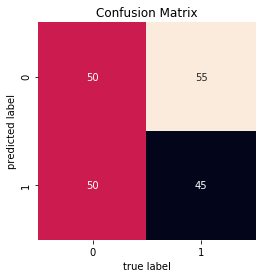

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Multi-ROC Curve: 
The <class 'sklearn.linear_model.ridge.RidgeClassifier'> classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.
Regions identified by the Classifier in the Training Set: 


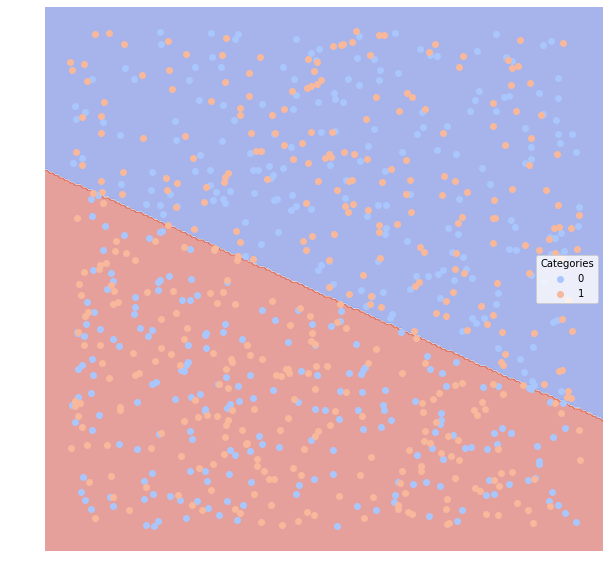

In [27]:
# Use `RidgeClassifier` for the `random` artificial data
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(data_generator_dict["random"]())
clf = sklearn.linear_model.RidgeClassifier(alpha=.5)
clf.fit(np.stack(dfTrain["vect"], axis=0), dfTrain["category"])

print("Data Generating Method: random")
print("Noise: ", noise)
print("Classification Model: Ridge Classifier")
print(lucem_illud_2020.evaluateClassifier(clf, dfTest))
print("Confusion Matrix: ")
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
print("Multi-ROC Curve: ")
lucem_illud_2020.plotMultiROC(clf, dfTest)
print("Regions identified by the Classifier in the Training Set: ")
lucem_illud_2020.plotregions(clf, dfTrain)

Loading Reddit data
Converting to vectors
Corpus: Reddit
Classification Model: Ridge Classifier
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Weeaboo Tales              0.015674  0.972600   0.986842           0.949415   
Bad Roommates              0.018809  0.975943   0.964706           0.940062   
Tales From Tech Support    0.006270  0.995745   0.976744           0.976744   
Relationships              0.003135  0.997984   0.986111           0.986111   

                           Recall  
Category                           
Weeaboo Tales            0.949367  
Bad Roommates            0.964706  
Tales From Tech Support  1.000000  
Relationships            1.000000  
Confusion Matrix: 


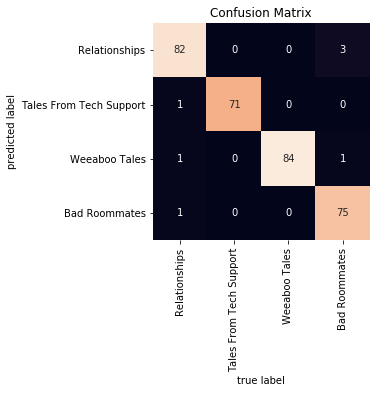

Multi-ROC Curve: 
The <class 'sklearn.linear_model.ridge.RidgeClassifier'> classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.
Regions identified by the Classifier in the Training Set: 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

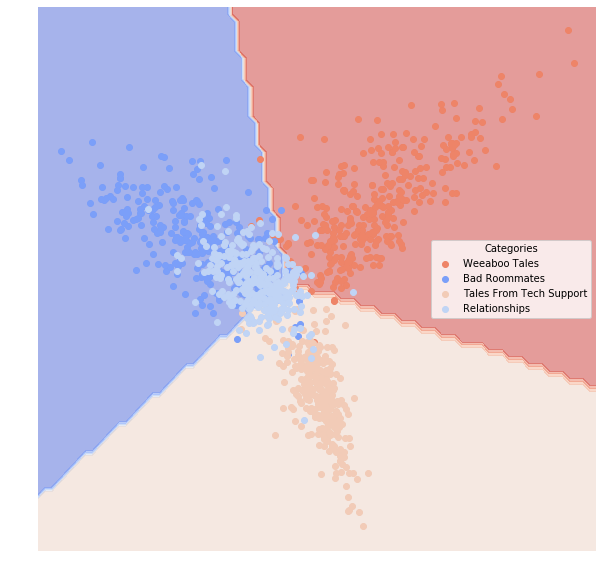

In [28]:
# Use `RidgeClassifier` for the `Reddit` dataset
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
clf = sklearn.linear_model.RidgeClassifier(alpha=.5)
clf.fit(np.stack(dfTrain["vect"], axis=0), dfTrain["category"])

print("Corpus: Reddit")
print("Classification Model: Ridge Classifier")
print(lucem_illud_2020.evaluateClassifier(clf, dfTest))
print("Confusion Matrix: ")
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
print("Multi-ROC Curve: ")
lucem_illud_2020.plotMultiROC(clf, dfTest)
print("Regions identified by the Classifier in the Training Set: ")
lucem_illud_2020.plotregions(clf, dfTrain)

### Comments

Ridge classifier first converts the target values into `{-1, 1}` and then treats the problem as a regression task (multi-output regression in the multiclass-case), as shown in the [sklearn documentation for the ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html).

When fitting the artificial data generated by `random`, it performs quite poorly not only due to the randomness of the data but also because of the linearity of the model itself. When classifying the real-life `Reddit thread` data, it does a comparatively precise classification with AUC above 0.97 in each category, whose performance ranks merely behind the best two classifiers, **SVM with `kernal=linear`** and **neural network**, and clearly before other methods.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [29]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with `pandas`, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates dataframe, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using `pandas.read_csv` function, we take in the csv file and convert it into a data frame. 

In [30]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [31]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Dec2007Obama192.txt,raw/Obama/10Dec2007Obama192.txt,Statement of Senator Barack Obama on Intern...,Obama
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2007Obama472.txt,raw/Obama/10Jan2007Obama472.txt,Legislation to Increase Availability and Us...,Obama
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Obama165.txt,raw/Obama/10Jan2008Obama165.txt,Obama Statement on the Flooding in East Cen...,Obama
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama28.txt,raw/Obama/10Jul2008Obama28.txt,Obama Green Applaud House Passage of Bill ...,Obama
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama29.txt,raw/Obama/10Jul2008Obama29.txt,Obama Joins Schumer and McCaskill to Call o...,Obama


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [32]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

In [33]:
ObamaClintonReleases["category"]

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
1679    False
1680    False
1681    False
1682    False
1683    False
1684    False
1685    False
1686    False
1687    False
1688    False
1689    False
1690    False
1691    False
1692    False
1693    False
1694    False
1695    False
1696    False
1697    False
1698    False
1699    False
1700    False
1701    False
1702    False
1703    False
1704    False
1705    False
1706    False
1707    False
1708    False
Name: category, Length: 1709, dtype: bool

Tokenize and normalize

In [34]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [35]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [36]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a **[tf-idf matrix](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)**(`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [37]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is `TfidfVectorizer`, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means *term frequency-inverse document frequency*, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to `l2`, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to `l1`, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

`fit_transform()` literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [38]:
TFVects.shape

(1368, 11474)

In [39]:
# help(TFVects)
TFVects.data

array([0.10389927, 0.53458096, 0.40813658, ..., 0.10339551, 0.11506332,
       0.1199059 ])

We can save this in the dataframe to make things easier

In [40]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what `todense()` does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11354 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a **dimension reduction**. First, we will approah this with **PCA**. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [41]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [42]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


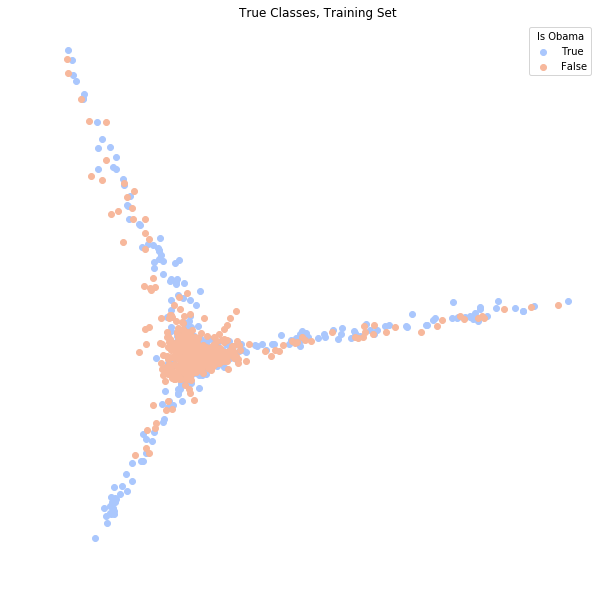

In [43]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors=2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c=pallet[0], label="True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c=pallet[1], label="False")
    
ax.legend(loc='upper right', title='Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a **screeplot** to see how many Principal Components we need.

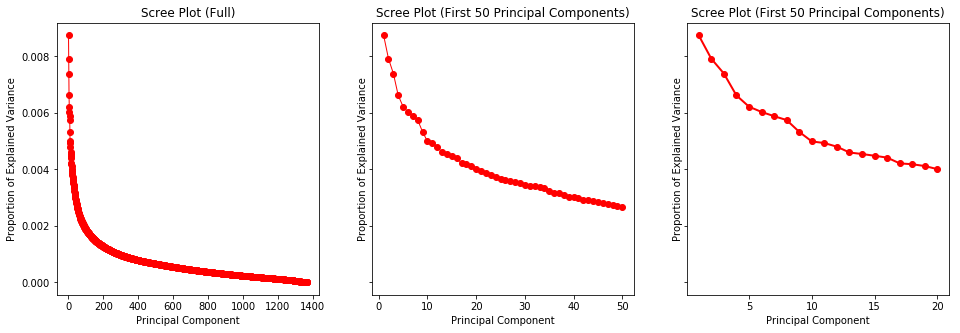

In [44]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [45]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [46]:
train_data_df.head()

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text,vect,pca,pca_reduced_10
1282,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16Jul2007Clinton573.txt,raw/Clinton/16Jul2007Clinton573.txt,July 16 2007 Schumer Clinton Announce Over ...,Clinton,False,"[July, 16, 2007, Schumer, Clinton, Announce, O...","[july, schumer, clinton, announce, great, bing...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03775628830404041, -0.031212783411552803, ...","[-0.03775628830404041, -0.031212783411552803, ..."
1539,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,19Dec2005Clinton20.txt,raw/Clinton/19Dec2005Clinton20.txt,December 19 2005 Schumer Clinton Announce Co...,Clinton,False,"[December, 19, 2005, Schumer, Clinton, Announc...","[december, schumer, clinton, announce, congres...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.023277236023157205, -0.004501616233923941,...","[-0.023277236023157205, -0.004501616233923941,..."
397,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,25Apr2008Obama94.txt,raw/Obama/25Apr2008Obama94.txt,Statement from Senator Barack Obama on Worl...,Obama,True,"[Statement, from, Senator, Barack, Obama, on, ...","[statement, senator, barack, obama, world, mal...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01518889695507333, -0.006810482445318262, ...","[-0.01518889695507333, -0.006810482445318262, ..."
180,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,17Mar2008Obama126.txt,raw/Obama/17Mar2008Obama126.txt,Durbin Obama Statement Regarding CME Acqui...,Obama,True,"[Durbin, Obama, Statement, Regarding, CME, Acq...","[durbin, obama, statement, cme, acquisition, n...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.016962311914320013, -0.007721127182019478,...","[-0.016962311914320013, -0.007721127182019478,..."
718,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Clinton239.txt,raw/Clinton/10Aug2006Clinton239.txt,August 10 2006 Senator Clinton Calls on VA Se...,Clinton,False,"[August, 10, 2006, Senator, Clinton, Calls, on...","[august, senator, clinton, call, va, secretary...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5212825641054808, 0.08358586181057316, 0.19...","[0.5212825641054808, 0.08358586181057316, 0.19..."


Now we fit a logistic regression to our data.

In [47]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [48]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6783625730994152

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [49]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6510263929618768

Slightly poorer. How about using more dimensions (40)?

In [50]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7543859649122807
Testing:
0.7155425219941349


Or still more (100)?

In [51]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8369883040935673
Testing:
0.7565982404692082


Or even more (200)!

In [52]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.868421052631579
Testing:
0.7771260997067448


This is becoming ridiculous (400)!

In [53]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9108187134502924
Testing:
0.7976539589442815


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try **a logistic regression that uses the TF-IDF scores for each word**, but with an **L1 regularization or L1-norm loss function**, which is also known as **least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty**. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [54]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.956140350877193


Train the model using training data, and then test it on the testing data.

In [55]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8093841642228738


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with **Naive Bayes**. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [56]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [57]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9597953216374269
Testing:
0.8651026392961877


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [58]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [59]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.9037037037037037

Recall:

In [60]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.7870967741935484

F1-measure:

In [61]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8413793103448276

Let's take a look at how well our posterior distribution looks relative to the truth.

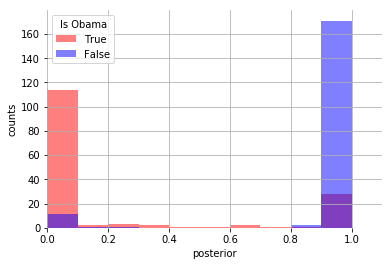

In [62]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha=.5, ax=ax, bins=10, label='True', color='red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha=.5, ax= ax, bins=10, label='False', color='blue')
ax.set_xlim((0,1.1))
ax.legend(title="Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [63]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,signature,-2.215778,5566,-1.756420
1,fy,-2.285574,amy,-1.854860
2,awarded,-2.297695,dick,-1.866421
3,island,-2.309965,brundage,-1.926319
4,ground,-2.347706,chicago,-2.003280
5,announcement,-2.360609,temporary,-2.209894
6,welcomed,-2.360609,reported,-2.277717
7,urging,-2.373681,va,-2.295417
8,welcome,-2.373681,location,-2.313435
9,urban,-2.413955,reform,-2.313435


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [64]:
#Free data to play with: documents from a newsgroup corpus.
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') 
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [65]:
#Can change these of course
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] 

newsgroupsDF = pandas.DataFrame(columns=['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories=[category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


In [66]:
newsgroupsDF

,text,category,source_file
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
5,"The primary problem in human nature is a ""frag...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
6,"\nJim, please, that's a lame explanation of th...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
7,\n->I addressed most of the key issues in this...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
8,\nWhere does it say in the bible that Christia...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
9,I addressed most of the key issues in this ver...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...


Now we need to tokenize, and make a training and testing set:

In [67]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [68]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [69]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [70]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [71]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [72]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8972721996517702


In [73]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
826,soc.religion.christian,soc.religion.christian
2034,comp.graphics,comp.graphics
600,soc.religion.christian,soc.religion.christian
799,soc.religion.christian,soc.religion.christian
1834,comp.graphics,comp.graphics
517,soc.religion.christian,soc.religion.christian
1587,comp.graphics,comp.graphics
397,soc.religion.christian,soc.religion.christian
1968,comp.graphics,comp.graphics
585,soc.religion.christian,soc.religion.christian


Looks pretty good, lets examine the testing dataset:

In [74]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7930232558139535


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

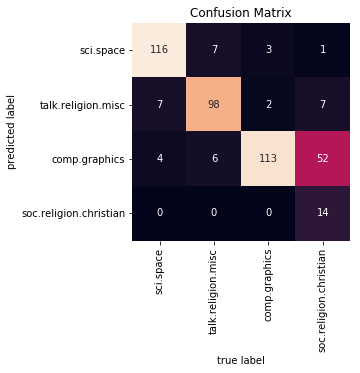

In [75]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [76]:
print("precison: ",sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average='weighted')) #precision
print("recall: ", sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print("f1 score: ",sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

precison:  0.8409659031299178
recall:  0.7930232558139535
f1 score:  0.7610601226167542


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [77]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.067442,0.916363,0.859649,0.789202,0.882883
soc.religion.christian,0.155814,0.879455,0.645714,0.629981,0.957627
talk.religion.misc,0.139535,0.594595,1.000000,0.328724,0.189189
comp.graphics,0.051163,0.938541,0.913386,0.859855,0.913386


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

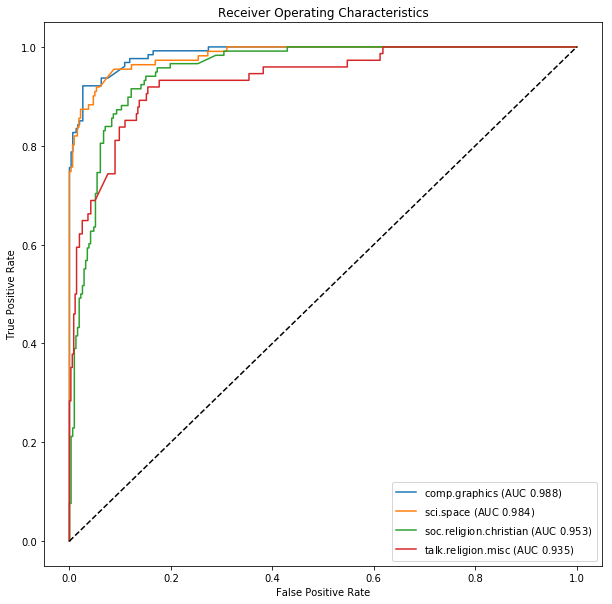

In [78]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

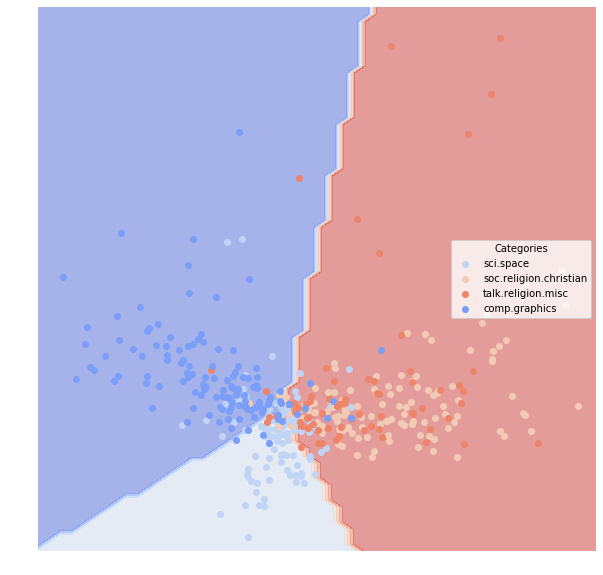

In [79]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


For this assignment, I will focus on positive and negative sentiment classification on first-person narratives that are drawn from the Spinn3r corpus that covers a wide range of topics. The `Coded` folder contains 498 positive and 754 negative sentences hand-coded by Amazon Turkers.

For more details about the corpus, please refer to [L. Reed, J. Wu, S. Oraby, P. Anand, and M. Walker. **"Learning Lexical-Functional Patterns for First-Person Sentiment."** in the Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (ACL). Vancouver, Canada. 2017.](https://nlds.soe.ucsc.edu/first-person-sentiment)

#### Logistic Regression

In [80]:
# Load the corpus
text = []
sentiment = []

for filename in os.listdir("first_person_sentiment/coded/pos/"):
    if filename.endswith(".txt"):
        file = "first_person_sentiment/coded/pos/" + filename
        with open(file) as f:
            text.append(f.read())
            sentiment.append(1)

for filename in os.listdir("first_person_sentiment/coded/neg/"):
    if filename.endswith(".txt"):
        file = "first_person_sentiment/coded/neg/" + filename
        with open(file) as f:
            text.append(f.read())
            sentiment.append(0)
            
# Convert to DataFrame
text_df = pd.DataFrame(data={
    "sentence": text,
    "category": sentiment
})

In [81]:
# Take a look at the DataFrame
text_df.sample(10, random_state=25)

,sentence,category
302,"So I think that will keep me busy, I need to b...",1
746,I am the only person in the class who hasn't t...,0
858,That we ARE naive ignorant Americans!!,0
113,"Usain Bolt celebrates, I would have, too.",1
906,"I think she thinks she has a nice body, but sh...",0
120,Full Sail's lax dress code has afforded me a c...,1
1094,"I was having problems with the heat, and I rea...",0
615,But they got worse lately and I'm at one of th...,0
1123,"I went to a perverts party last night, the per...",0
1001,I asked her if she felt as though she could cr...,0


In [82]:
# Tokenize and normalize the text data
text_df["tokenized"] = text_df["sentence"].apply(lambda x: lucem_illud_2020.word_tokenize(x))
text_df["normalized"] = text_df["tokenized"].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
text_df.sample(10, random_state=25)

,sentence,category,tokenized,normalized
302,"So I think that will keep me busy, I need to b...",1,"[So, I, think, that, will, keep, me, busy, I, ...","[think, busy, need, creative]"
746,I am the only person in the class who hasn't t...,0,"[I, am, the, only, person, in, the, class, who...","[person, class, take, sort, dance, class, year]"
858,That we ARE naive ignorant Americans!!,0,"[That, we, ARE, naive, ignorant, Americans]","[naive, ignorant, americans]"
113,"Usain Bolt celebrates, I would have, too.",1,"[Usain, Bolt, celebrates, I, would, have, too]","[usain, bolt, celebrate]"
906,"I think she thinks she has a nice body, but sh...",0,"[I, think, she, thinks, she, has, a, nice, bod...","[think, think, nice, body, pouch]"
120,Full Sail's lax dress code has afforded me a c...,1,"[Full, Sail, 's, lax, dress, code, has, afford...","[sail, lax, dress, code, afford, closet, jeans..."
1094,"I was having problems with the heat, and I rea...",0,"[I, was, having, problems, with, the, heat, an...","[have, problem, heat, want, ask, leave, tell, ..."
615,But they got worse lately and I'm at one of th...,0,"[But, they, got, worse, lately, and, I, 'm, at...","[get, wrong, lately, be, low, weight, have, ha..."
1123,"I went to a perverts party last night, the per...",0,"[I, went, to, a, perverts, party, last, night,...","[go, pervert, party, night, pervert, bloke, team]"
1001,I asked her if she felt as though she could cr...,0,"[I, asked, her, if, she, felt, as, though, she...","[ask, feel, cross, highway, give, resound]"


In [83]:
# Split into training and testing datasets
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(text_df, holdBackFraction=holdBackFraction)

In [84]:
len(train_data_df), len(test_data_df)

(1002, 250)

In [85]:
# Turn the training dataset into a tf-idf matrix and vectorize text data using normalized text
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words="english", norm="l2")
TFVects = TFVectorizer.fit_transform([" ".join(s) for s in train_data_df["normalized"]])
train_data_df["vect"] = [np.array(v).flatten() for v in TFVects.todense()]

In [86]:
# Train the model
clf0 = sklearn.linear_model.LogisticRegression(penalty="l2")
clf0.fit(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [87]:
# Calculate the score of fitting the training set
clf0.score(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

0.8353293413173652

In [88]:
# Turn the testing dataset into a rf-idf matrix and vectorize text data using normalized text
TFVects_test = TFVectorizer.transform(test_data_df["sentence"])
test_data_df["vect"] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [89]:
# Calculate the score of fitting the testing set
clf0.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])

0.692

In [90]:
# Evaluate the logistic regression classifier
lucem_illud_2020.evaluateClassifier(clf0, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.308,0.642734,0.683673,0.674847,0.899329
1,0.308,0.642734,0.722222,0.526878,0.386139


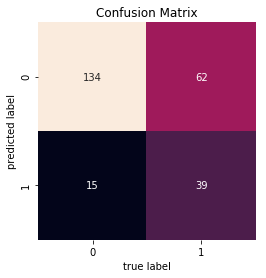

In [91]:
# Plot the confusion matrix
lucem_illud_2020.plotConfusionMatrix(clf0, test_data_df)

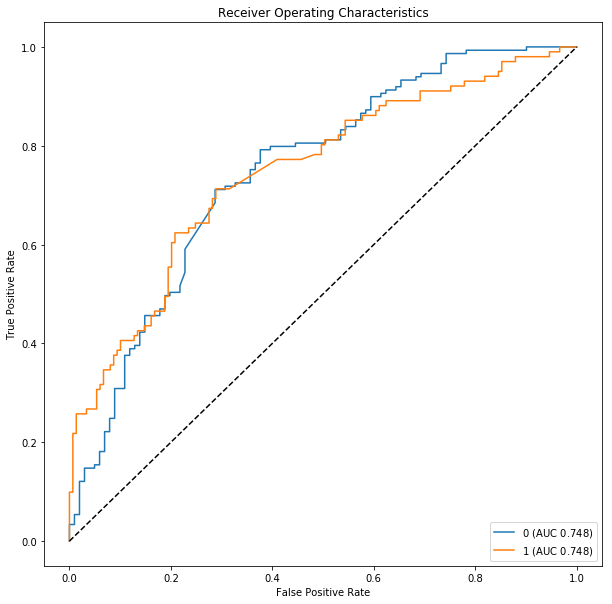

In [92]:
# Plot the ROC curves
lucem_illud_2020.plotMultiROC(clf0, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


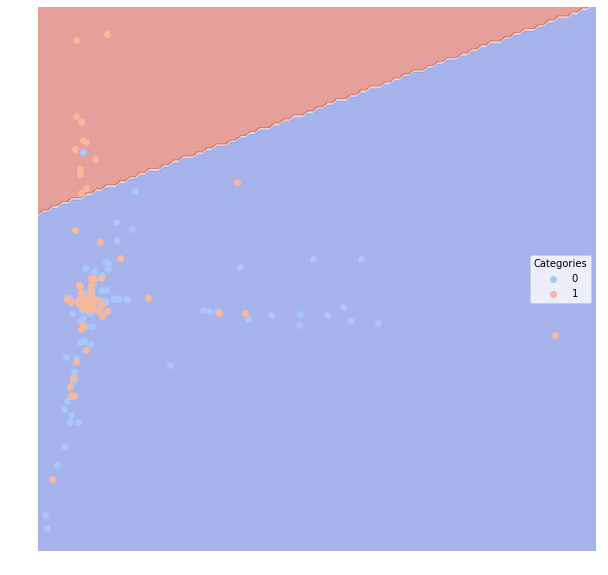

In [93]:
# Plot the PCA space visualization
lucem_illud_2020.plotregions(clf0, test_data_df)

Implement the classifier to the uncoded data.

In [94]:
# Load the uncoded text
text = []
for filename in os.listdir("first_person_sentiment/uncoded/"):
    if filename.endswith(".txt"):
        file = "first_person_sentiment/uncoded/" + filename
        with open(file) as f:
            text.append(f.read())
# Convert into DataFrame
uncoded_df = pd.DataFrame(data={"sentence": text})

In [95]:
# Tokenize and normalize the uncoded data
uncoded_df["tokenized"] = uncoded_df["sentence"].apply(lambda x: lucem_illud_2020.word_tokenize(x))
uncoded_df["normalized"] = uncoded_df["tokenized"].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [96]:
# Turn the uncoded dataset into a tf-idf matrix and vectorize text data using normalized text
TFVects_uncoded = TFVectorizer.transform([" ".join(s) for s in uncoded_df["normalized"]])
uncoded_df["vect"] = [np.array(v).flatten() for v in TFVects_uncoded.todense()]

In [97]:
# Perform classification predictions for the uncoded dataset using the trained logistic model
uncoded_df["predict_logistic"] = clf0.predict(np.stack(uncoded_df["vect"], axis=0))

In [98]:
# Take a look at the predicted result
uncoded_df[["sentence", "predict_logistic"]].sample(10, random_state=25)

,sentence,predict_logistic
2009,Have I grown up or am I just not being true to...,0
1373,I wanna get away.,1
2293,I was amazed afterwards.,1
1292,"Also, I lied so much in my past until I can't ...",0
1110,But it cost me $109!,0
1103,"However, I'll be making good money, so it does...",1
1872,On another shallow shopping note I think after...,0
2578,"So eventually she said ""I know you aint talkin...",0
1165,I'll feel so much better after Monday.,0
2181,My mom was going to be so mad at me.,0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


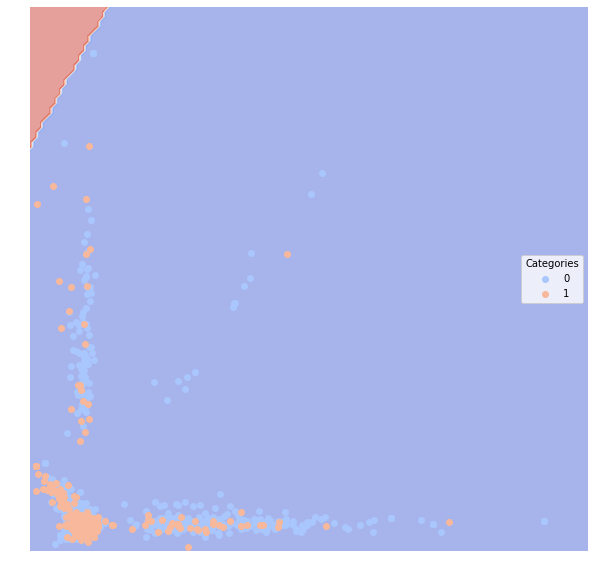

In [99]:
# Plot the PCA space visualization
uncoded_df["category"] = uncoded_df["predict_logistic"]
lucem_illud_2020.plotregions(clf0, uncoded_df)

#### Naive Bayes

In [100]:
# Train the model
clf1 = sklearn.naive_bayes.BernoulliNB()
clf1.fit(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [101]:
# Calculate the score of fitting the training set
clf1.score(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

0.8672654690618763

In [102]:
# Calculate the score of fitting the testing set
clf1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])

0.732

In [103]:
# Evaluate the naive bayes classifier
lucem_illud_2020.evaluateClassifier(clf1, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.268,0.693833,0.722826,0.709207,0.892617
1,0.268,0.693833,0.757576,0.579038,0.495050


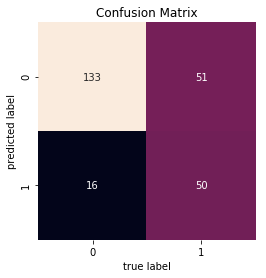

In [104]:
# Plot the confusion matrix
lucem_illud_2020.plotConfusionMatrix(clf1, test_data_df)

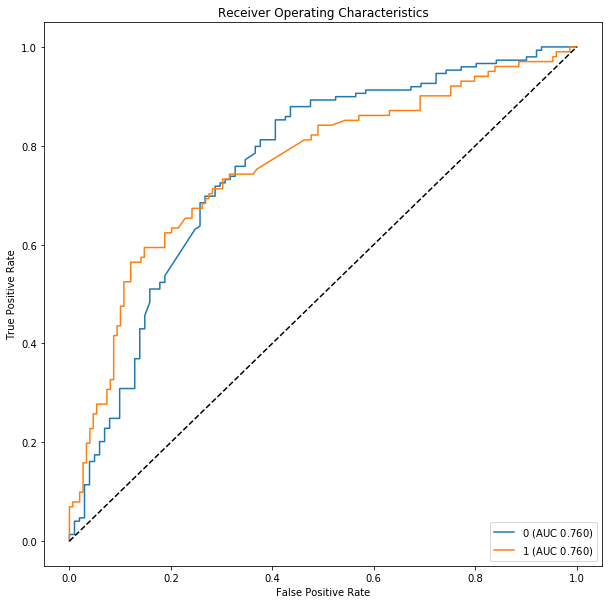

In [105]:
# Plot the ROC curves
lucem_illud_2020.plotMultiROC(clf1, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


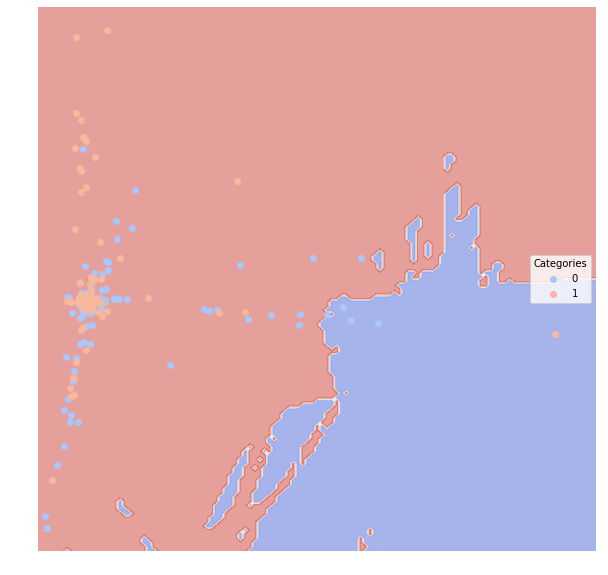

In [106]:
# Plot the PCA space visualization
lucem_illud_2020.plotregions(clf1, test_data_df)

In [107]:
# Perform classification predictions for the uncoded dataset using the trained logistic model
uncoded_df["predict_naive_bayes"] = clf1.predict(np.stack(uncoded_df["vect"], axis=0))

In [108]:
# Take a look at the predicted result
uncoded_df[["sentence", "predict_naive_bayes"]].sample(10, random_state=25)

,sentence,predict_naive_bayes
2009,Have I grown up or am I just not being true to...,0
1373,I wanna get away.,0
2293,I was amazed afterwards.,1
1292,"Also, I lied so much in my past until I can't ...",0
1110,But it cost me $109!,0
1103,"However, I'll be making good money, so it does...",1
1872,On another shallow shopping note I think after...,1
2578,"So eventually she said ""I know you aint talkin...",0
1165,I'll feel so much better after Monday.,0
2181,My mom was going to be so mad at me.,1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


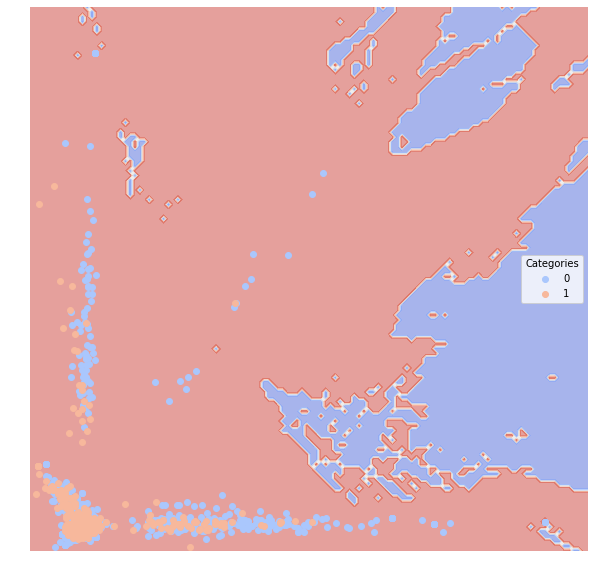

In [109]:
# Plot the PCA space visualization
uncoded_df["category"] = uncoded_df["predict_naive_bayes"]
lucem_illud_2020.plotregions(clf1, uncoded_df)

### Comments

For the first-person narration sentiment classification task, neither logistic regression nor naive Bayes has a satisfying performance. Since AUCs are 0.64 and 0.70 respectively for the two methods, the fittings are not reliable enough to produce accurate results.

According to the [paper](http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf) by professor Ng and professor Jordan which provides a mathematical proof of error properties of both models, "when the training size reaches infinity the discriminative model: logistic regression performs better than the generative model Naive Bayes", or in other words, the generative model (Naive Bayes) reaches the asymptotic solution for fewer training sets than the discriminative model (Logistic Regression). Therefore, since the hand-coded training set only contains 1002 observations, which can be considered as not large, the situation that the naive Bayes method slightly outperforms the logistic regression coincides with the above conclusion.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

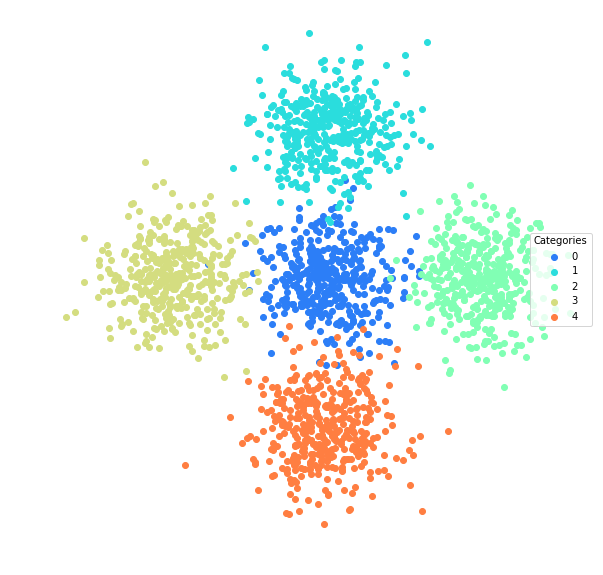

In [110]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [111]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4, random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis=0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

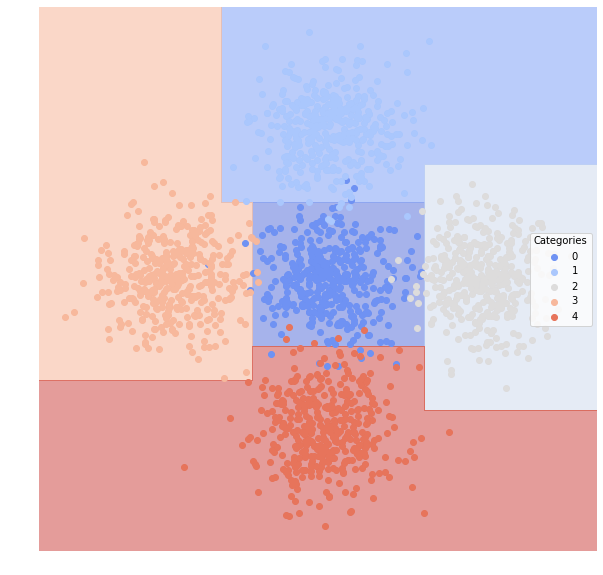

In [112]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [113]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.014,0.987694,0.946429,0.939583,0.990654
1,0.006,0.985149,1.000000,0.976297,0.970297
2,0.006,0.983696,1.000000,0.973391,0.967391
3,0.004,0.993930,0.990385,0.982862,0.990385
4,0.002,0.998762,0.989691,0.989691,1.000000


Lets look at accuracy:

In [114]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.984

What happens if we trim the tree?

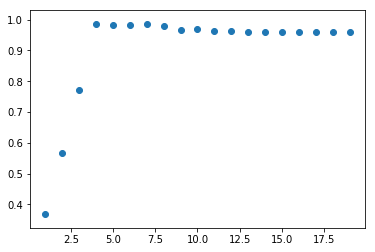

In [115]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i, random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis=0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, **suggesting that our model is overfitting beyond those four layers**.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [116]:
# Create an instance of our decision tree classifier.
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) 
# Each tree uses up to 80% of the data
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

In [117]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

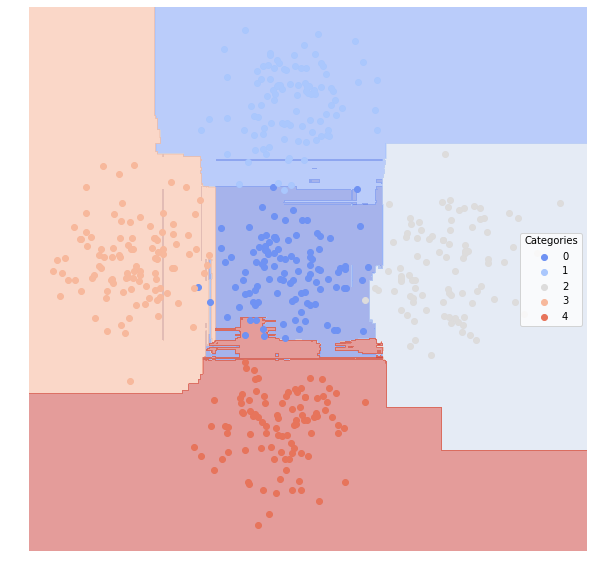

In [118]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [119]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.024,0.957528,0.961165,0.905302,0.925234
1,0.010,0.982642,0.980000,0.956891,0.970297
2,0.002,0.994565,1.000000,0.991130,0.989130
3,0.002,0.998737,0.990476,0.990476,1.000000
4,0.010,0.993812,0.950495,0.950495,1.000000


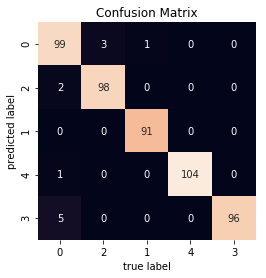

In [120]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

#### Decision Tree

In [121]:
# Train the model
clf2 = sklearn.tree.DecisionTreeClassifier(max_depth=30, random_state=25)
clf2.fit(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=25,
            splitter='best')

In [122]:
# Calculate the score of fitting the training set
clf2.score(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

0.7764471057884231

In [123]:
# Calculate the score of fitting the testing set
clf2.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])

0.668

In [124]:
# Evaluate the naive bayes classifier
lucem_illud_2020.evaluateClassifier(clf2, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.332,0.609841,0.660194,0.654593,0.912752
1,0.332,0.609841,0.704545,0.496247,0.306931


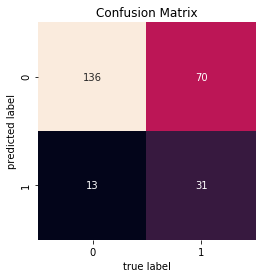

In [125]:
# Plot the confusion matrix
lucem_illud_2020.plotConfusionMatrix(clf2, test_data_df)

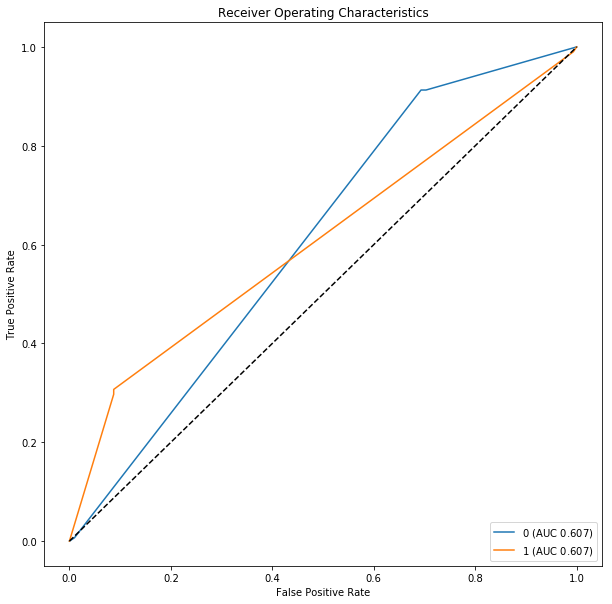

In [126]:
# Plot the ROC curves
lucem_illud_2020.plotMultiROC(clf2, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


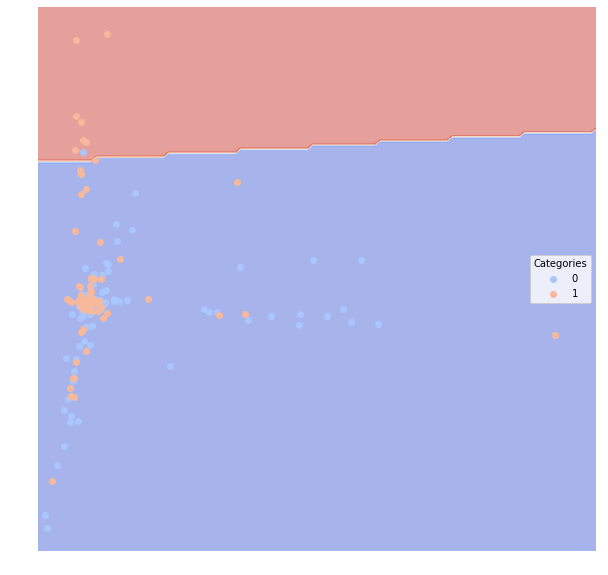

In [127]:
# Plot the PCA space visualization
lucem_illud_2020.plotregions(clf2, test_data_df)

In [128]:
# Perform classification predictions for the uncoded dataset using the trained logistic model
uncoded_df["predict_decision_tree"] = clf2.predict(np.stack(uncoded_df["vect"], axis=0))

In [129]:
# Take a look at the predicted result
uncoded_df[["sentence", "predict_decision_tree"]].sample(10, random_state=25)

,sentence,predict_decision_tree
2009,Have I grown up or am I just not being true to...,0
1373,I wanna get away.,0
2293,I was amazed afterwards.,1
1292,"Also, I lied so much in my past until I can't ...",0
1110,But it cost me $109!,0
1103,"However, I'll be making good money, so it does...",1
1872,On another shallow shopping note I think after...,0
2578,"So eventually she said ""I know you aint talkin...",0
1165,I'll feel so much better after Monday.,0
2181,My mom was going to be so mad at me.,0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


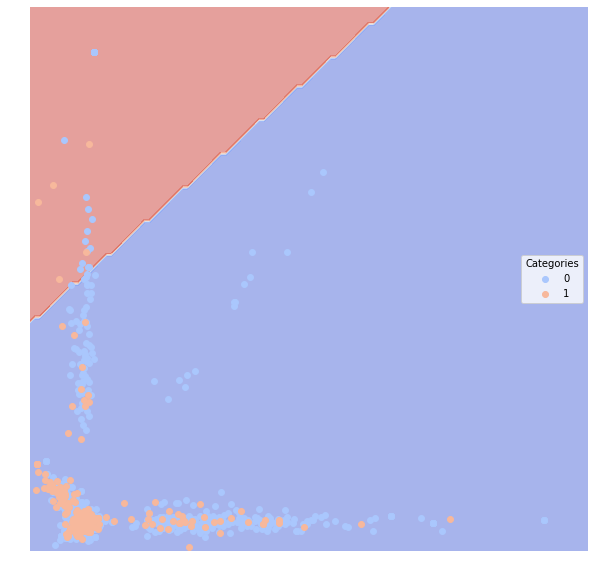

In [130]:
# Plot the PCA space visualization
uncoded_df["category"] = uncoded_df["predict_decision_tree"]
lucem_illud_2020.plotregions(clf2, uncoded_df)

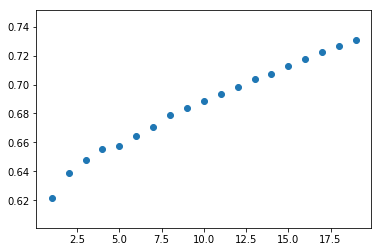

In [131]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree = sklearn.tree.DecisionTreeClassifier(max_depth=i, random_state=0)
    tree.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(train_data_df['category'], tree.predict(np.stack(train_data_df['vect'], axis=0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

### Comments

Decision tree has an even weaker performance on this task compared to logistic regression and naive Bayes with a low level of accuracy (0.61) and a high level of error rates (0.33). By iteratively trimming the tree, the graph above suggests that there is no overfitting problem even with `max_depth=20`. Therefore, the bagging method is expected to have better performance by introducing randomization into its construction procedure and then making an ensemble out of it.

#### Random Forest (A Ensemble Method)

In [132]:
# Train the model
clf3 = sklearn.tree.DecisionTreeClassifier(max_depth=30, random_state=25)
bag = sklearn.ensemble.BaggingClassifier(clf3, n_estimators=100, max_samples=0.8, random_state=1)
bag.fit(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=25,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [133]:
# Calculate the score of fitting the training set
bag.score(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

0.8033932135728543

In [134]:
# Calculate the score of fitting the testing set
bag.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])

0.716

In [135]:
# Evaluate the naive bayes classifier
lucem_illud_2020.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.284,0.659678,0.689320,0.684936,0.953020
1,0.284,0.659678,0.840909,0.564056,0.366337


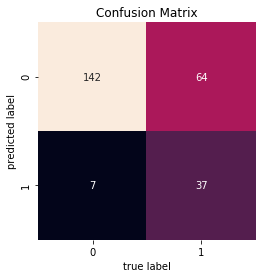

In [136]:
# Plot the confusion matrix
lucem_illud_2020.plotConfusionMatrix(bag, test_data_df)

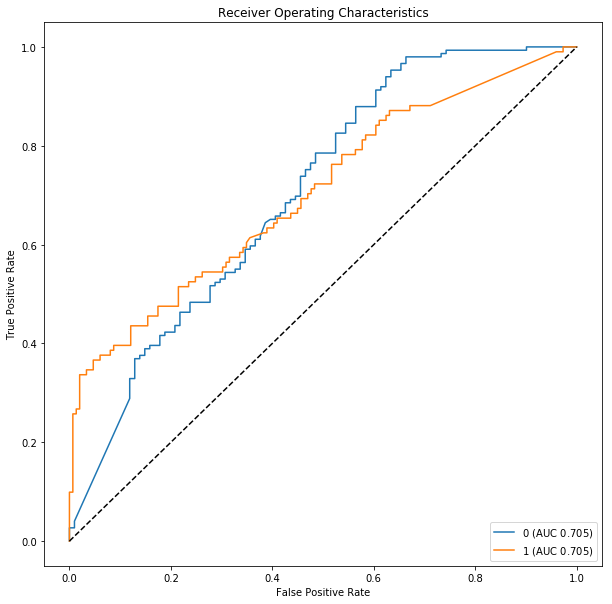

In [137]:
# Plot the ROC curves
lucem_illud_2020.plotMultiROC(bag, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


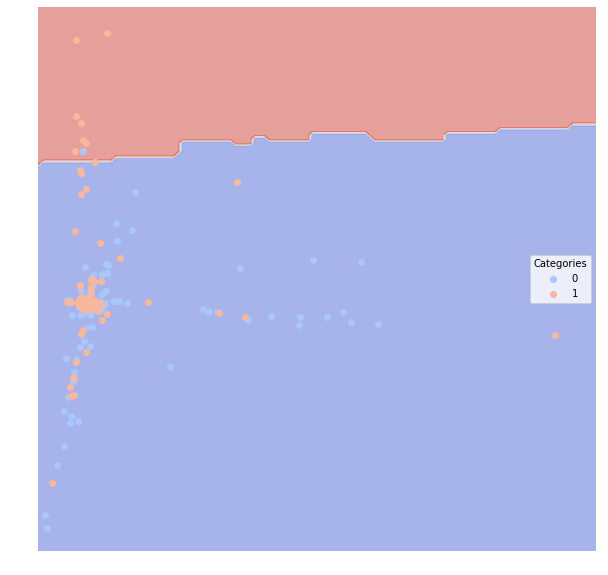

In [138]:
# Plot the PCA space visualization
lucem_illud_2020.plotregions(bag, test_data_df)

In [139]:
# Perform classification predictions for the uncoded dataset using the trained logistic model
uncoded_df["predict_random_forest"] = bag.predict(np.stack(uncoded_df["vect"], axis=0))

In [140]:
# Take a look at the predicted result
uncoded_df[["sentence", "predict_random_forest"]].sample(10, random_state=25)

,sentence,predict_random_forest
2009,Have I grown up or am I just not being true to...,0
1373,I wanna get away.,0
2293,I was amazed afterwards.,1
1292,"Also, I lied so much in my past until I can't ...",0
1110,But it cost me $109!,0
1103,"However, I'll be making good money, so it does...",1
1872,On another shallow shopping note I think after...,0
2578,"So eventually she said ""I know you aint talkin...",1
1165,I'll feel so much better after Monday.,0
2181,My mom was going to be so mad at me.,0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


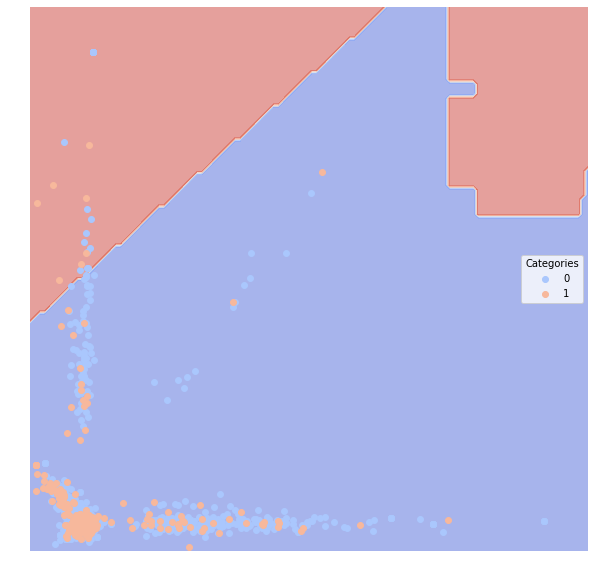

In [141]:
# Plot the PCA space visualization
uncoded_df["category"] = uncoded_df["predict_random_forest"]
lucem_illud_2020.plotregions(bag, uncoded_df)

### Comments

Ensemble learning methods corporate the results of multiple methods and are supposed to obtain better outcomes than that could be attained from any single learning algorithm that is integrated by the ensemble method. In this example, the bagging method employs 100 decision tree estimators and each tree uses up to 80% of the data to perform the classification and give the final result.

The performance of the bagging method is not satisfying again with a low AUC (0.66) and high error rates (0.28). Nevertheless, there is no denying the fact that bagging does produce better classification results in contrast with the decision tree above (AUC=0.61 and error rates=0.33).

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [142]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[be, sorry, read, commandment]"


Make a testing and training set:

In [143]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [144]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [145]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [146]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [147]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.graphics,0.201973,0.700003,0.663717,0.461161,0.490196
sci.space,0.258270,0.720363,0.517298,0.436784,0.673820
talk.religion.misc,0.352873,0.662349,0.293223,0.257473,0.686084
soc.religion.christian,0.252467,0.555215,1.000000,0.362896,0.110429


And lets look at the testing data

In [148]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.2744186046511628


Let's produce another confusion matrix:

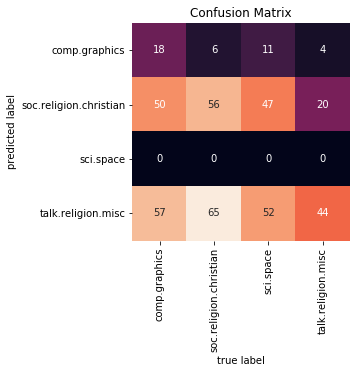

In [149]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

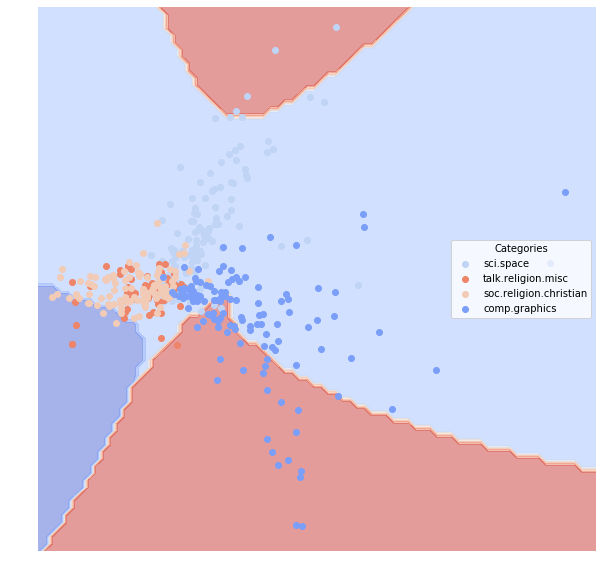

In [150]:
lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [151]:
# Initialize a k-nearest neighbor classifier and train the model
n_neighbors = 15
weights="uniform"
clf3 = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf3.fit(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [152]:
# Calculate the score of fitting the training set
clf3.score(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

0.7305389221556886

In [153]:
# Calculate the score of fitting the testing set
clf3.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])

0.636

In [154]:
# Evaluate the naive bayes classifier
lucem_illud_2020.evaluateClassifier(clf3, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.364,0.565453,0.631818,0.629414,0.932886
1,0.364,0.565453,0.666667,0.456013,0.198020


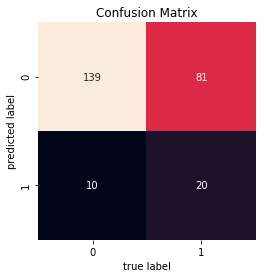

In [155]:
# Plot the confusion matrix
lucem_illud_2020.plotConfusionMatrix(clf3, test_data_df)

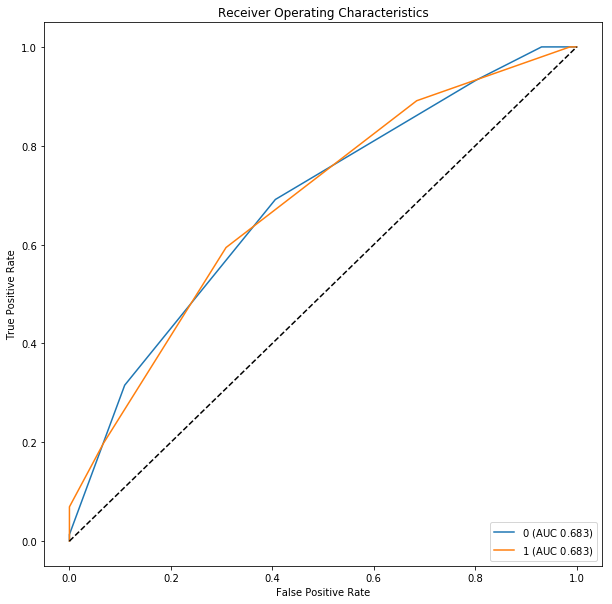

In [156]:
# Plot the ROC curves
lucem_illud_2020.plotMultiROC(clf3, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


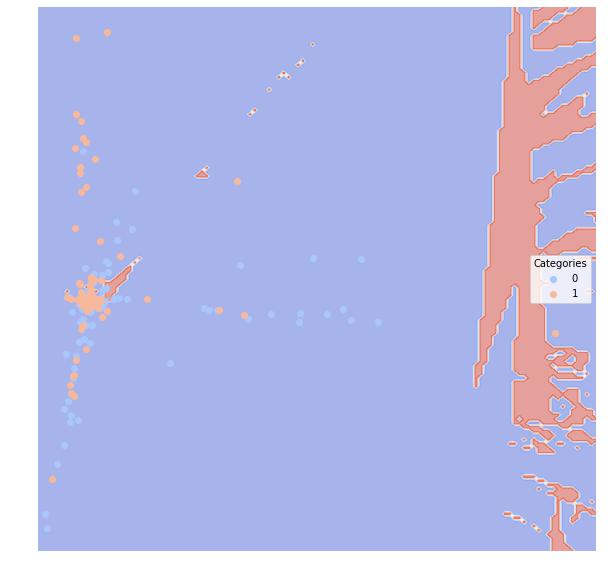

In [157]:
# Plot the PCA space visualization
lucem_illud_2020.plotregions(clf3, test_data_df)

In [158]:
# Perform classification predictions for the uncoded dataset using the trained logistic model
uncoded_df["predict_knearest"] = clf3.predict(np.stack(uncoded_df["vect"], axis=0))

In [159]:
# Take a look at the predicted result
uncoded_df[["sentence", "predict_knearest"]].sample(10, random_state=25)

,sentence,predict_knearest
2009,Have I grown up or am I just not being true to...,0
1373,I wanna get away.,0
2293,I was amazed afterwards.,1
1292,"Also, I lied so much in my past until I can't ...",0
1110,But it cost me $109!,0
1103,"However, I'll be making good money, so it does...",0
1872,On another shallow shopping note I think after...,0
2578,"So eventually she said ""I know you aint talkin...",1
1165,I'll feel so much better after Monday.,0
2181,My mom was going to be so mad at me.,0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


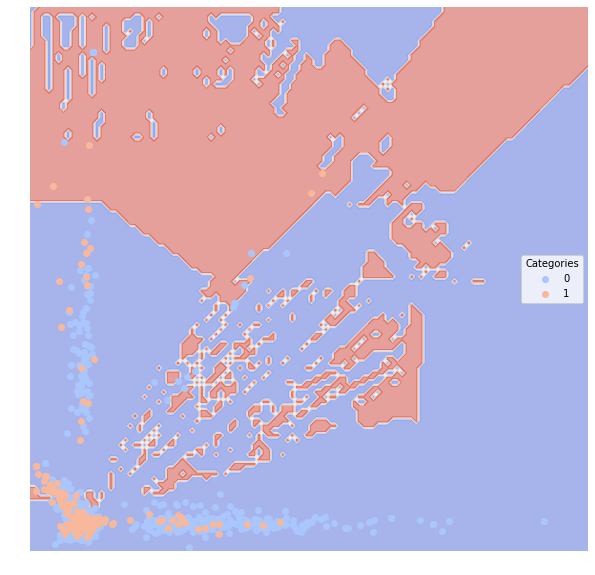

In [160]:
# Plot the PCA space visualization
uncoded_df["category"] = uncoded_df["predict_knearest"]
lucem_illud_2020.plotregions(clf3, uncoded_df)

### Comments

K-nearest neighbor fails to generate better results in comparison with the three above methods with 0.36 error rates and 0.57 AUC, but it is much more time-consuming.

K-means clustering is an unsupervised learning algorithm that gathers and group data into `k` number of clusters while k-nearest neighbor is a supervised learning method that will give new data points accordingly to the `k` number or the closest data points. K-means clustering utilized unlabelled data and is able to gradually learn how to cluster the unlabelled points into different groups by analysis of the mean distance of the points. In practice, k-means clustering algorithm is popularly used for scenarios such as getting a deeper understanding of demographics, social media trends, marketing strategies evolutions, and so on. The algorithm functions cluster the data in such a manner that minimizes the cost function. K-nearest neighbors algorithm is mainly used for **classification and regression** of given data when the attribute is already known.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [161]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values
redditDf = redditDf.dropna()

#Set category
redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [162]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [163]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [164]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability=False)
#probability=True is slower but lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

...and consider the results:

In [165]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.031348,0.965656,0.911392,0.884341,0.960000
Weeaboo Tales: stories about the extreme fans of japanese culture,0.012539,0.980790,0.988372,0.964082,0.965909
Tales From Tech Support,0.000000,1.000000,1.000000,1.000000,1.000000
Relationships,0.018809,0.971107,0.974684,0.939090,0.950617


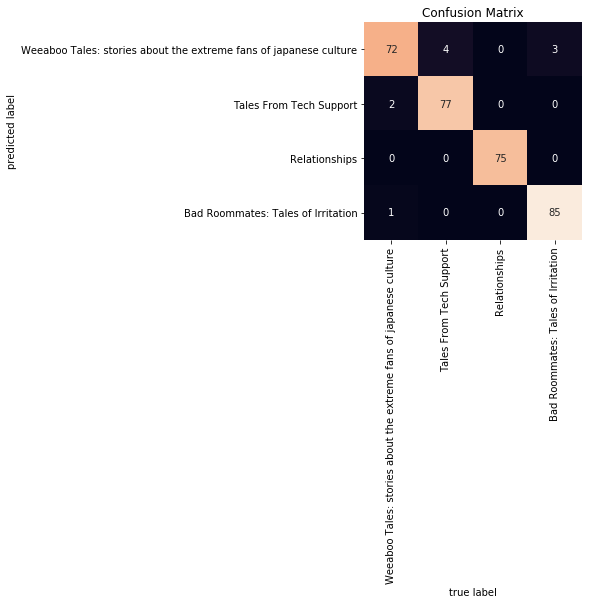

In [166]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

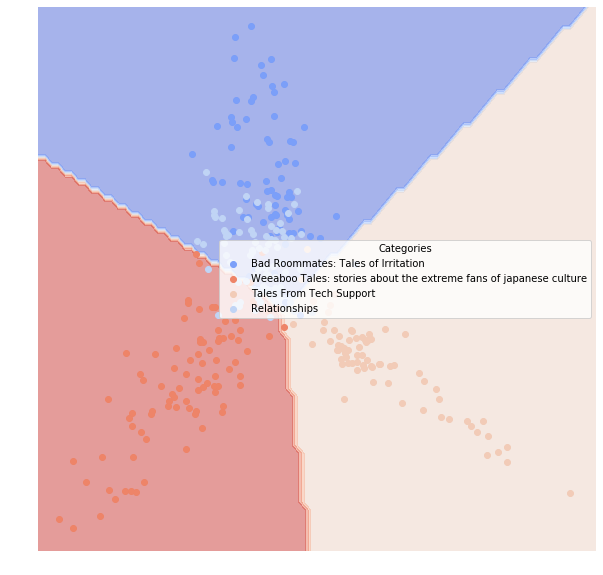

In [167]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, **the Multi-layer Perceptron (MLP)** that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [168]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [169]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.028213,0.972322,0.912500,0.894436,0.973333
Weeaboo Tales: stories about the extreme fans of japanese culture,0.015674,0.975108,0.988235,0.955855,0.954545
Tales From Tech Support,0.006270,0.995902,0.974026,0.974026,1.000000
Relationships,0.018809,0.967035,0.987013,0.941760,0.938272


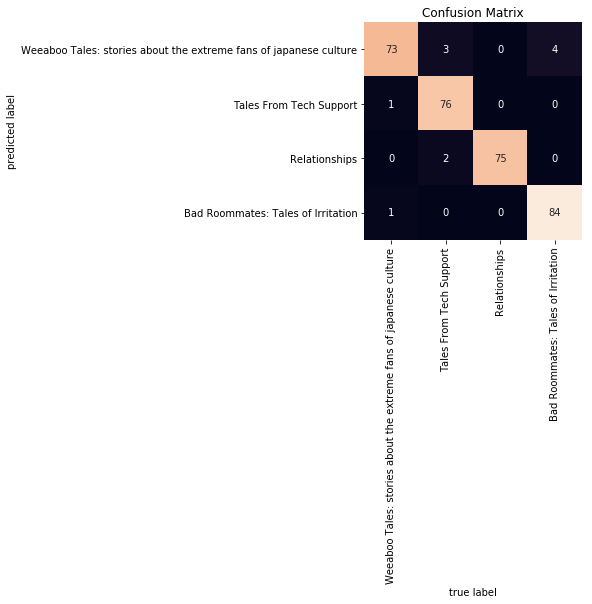

In [170]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

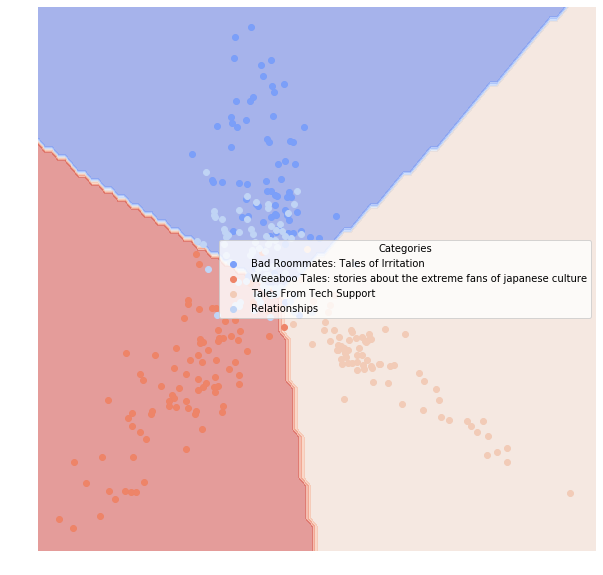

In [171]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

#### SVM

In [172]:
# Train the model
clf4 = sklearn.svm.SVC(kernel="linear", probability=True)
clf4.fit(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [173]:
# Calculate the score of fitting the training set
clf4.score(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

0.8872255489021956

In [174]:
# Calculate the score of fitting the testing set
clf4.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])

0.688

In [175]:
# Evaluate the naive bayes classifier
lucem_illud_2020.evaluateClassifier(clf4, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.312,0.650542,0.696133,0.680676,0.845638
1,0.312,0.650542,0.666667,0.523630,0.455446


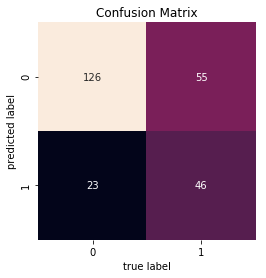

In [176]:
# Plot the confusion matrix
lucem_illud_2020.plotConfusionMatrix(clf4, test_data_df)

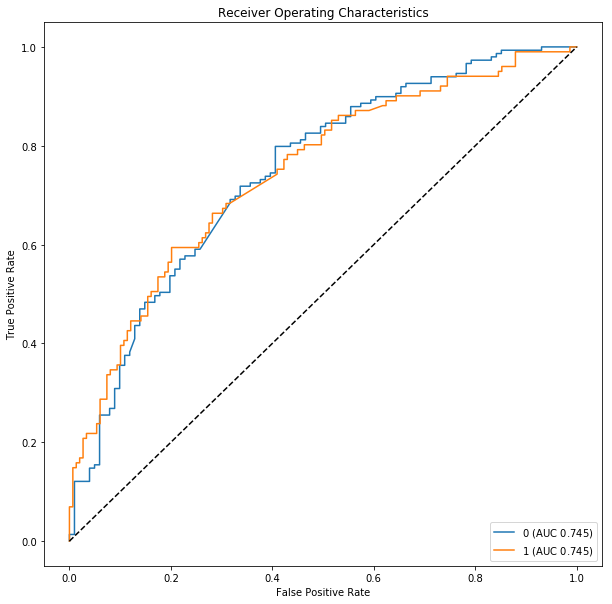

In [177]:
# Plot the ROC curves
lucem_illud_2020.plotMultiROC(clf4, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


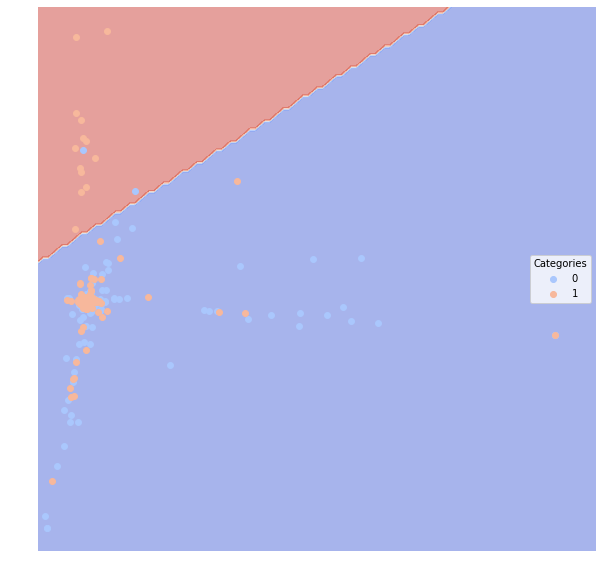

In [178]:
# Plot the PCA space visualization
lucem_illud_2020.plotregions(clf4, test_data_df)

In [179]:
# Perform classification predictions for the uncoded dataset using the trained logistic model
uncoded_df["predict_svm"] = clf4.predict(np.stack(uncoded_df["vect"], axis=0))

In [180]:
# Take a look at the predicted result
uncoded_df[["sentence", "predict_svm"]].sample(10, random_state=25)

,sentence,predict_svm
2009,Have I grown up or am I just not being true to...,0
1373,I wanna get away.,1
2293,I was amazed afterwards.,1
1292,"Also, I lied so much in my past until I can't ...",0
1110,But it cost me $109!,0
1103,"However, I'll be making good money, so it does...",1
1872,On another shallow shopping note I think after...,0
2578,"So eventually she said ""I know you aint talkin...",0
1165,I'll feel so much better after Monday.,0
2181,My mom was going to be so mad at me.,1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


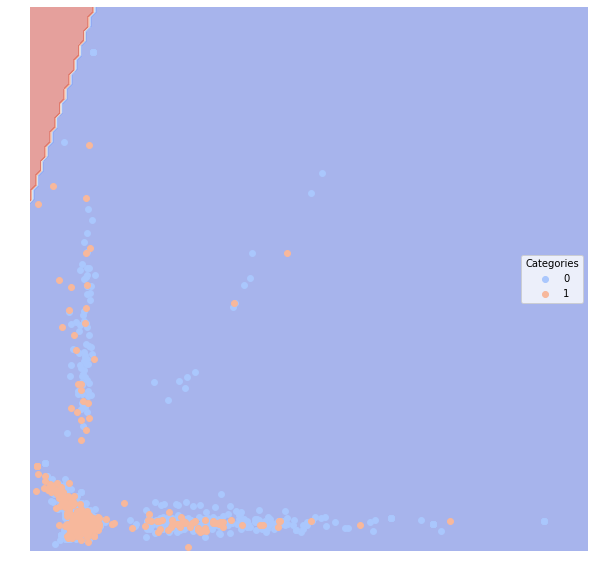

In [181]:
# Plot the PCA space visualization
uncoded_df["category"] = uncoded_df["predict_svm"]
lucem_illud_2020.plotregions(clf4, uncoded_df)

#### Neural Network

In [182]:
# Train the model
clf5 = sklearn.neural_network.MLPClassifier()
clf5.fit(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [183]:
# Calculate the score of fitting the training set
clf5.score(np.stack(train_data_df["vect"], axis=0), train_data_df["category"])

0.9860279441117764

In [184]:
# Calculate the score of fitting the testing set
clf5.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])

0.612

In [185]:
# Evaluate the naive bayes classifier
lucem_illud_2020.evaluateClassifier(clf5, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.388,0.617084,0.709677,0.663138,0.590604
1,0.388,0.617084,0.515873,0.475997,0.643564


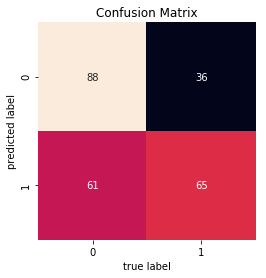

In [186]:
# Plot the confusion matrix
lucem_illud_2020.plotConfusionMatrix(clf5, test_data_df)

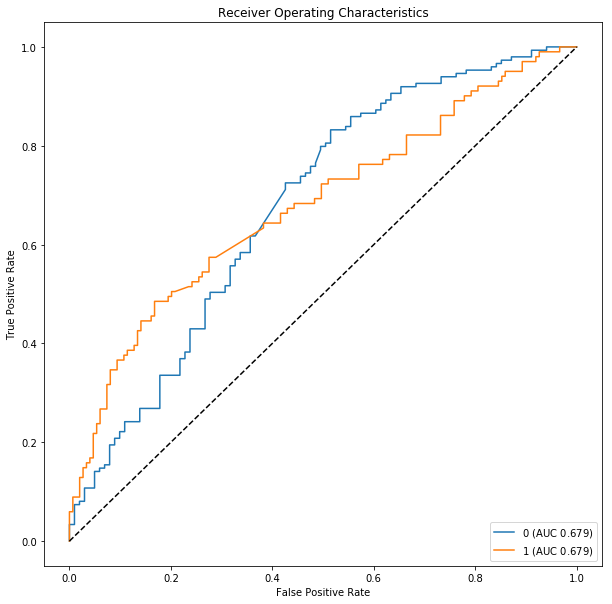

In [187]:
# Plot the ROC curves
lucem_illud_2020.plotMultiROC(clf5, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


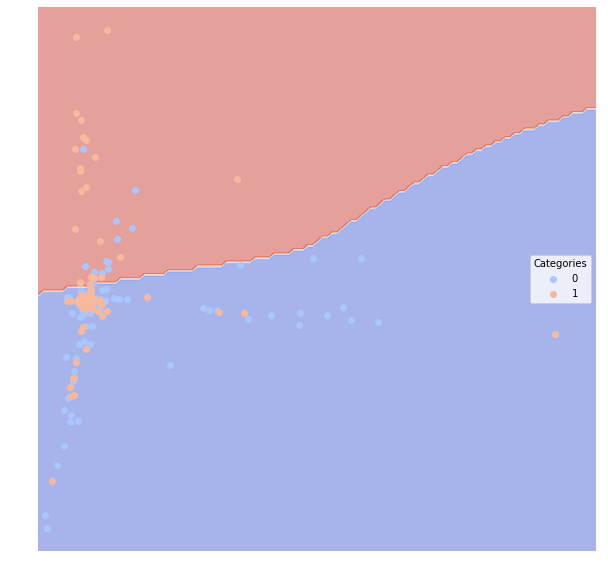

In [188]:
# Plot the PCA space visualization
lucem_illud_2020.plotregions(clf5, test_data_df)

In [189]:
# Perform classification predictions for the uncoded dataset using the trained logistic model
uncoded_df["predict_neural_net"] = clf5.predict(np.stack(uncoded_df["vect"], axis=0))

In [190]:
# Take a look at the predicted result
uncoded_df[["sentence", "predict_neural_net"]].sample(10, random_state=25)

,sentence,predict_neural_net
2009,Have I grown up or am I just not being true to...,0
1373,I wanna get away.,1
2293,I was amazed afterwards.,1
1292,"Also, I lied so much in my past until I can't ...",1
1110,But it cost me $109!,0
1103,"However, I'll be making good money, so it does...",1
1872,On another shallow shopping note I think after...,0
2578,"So eventually she said ""I know you aint talkin...",1
1165,I'll feel so much better after Monday.,1
2181,My mom was going to be so mad at me.,1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


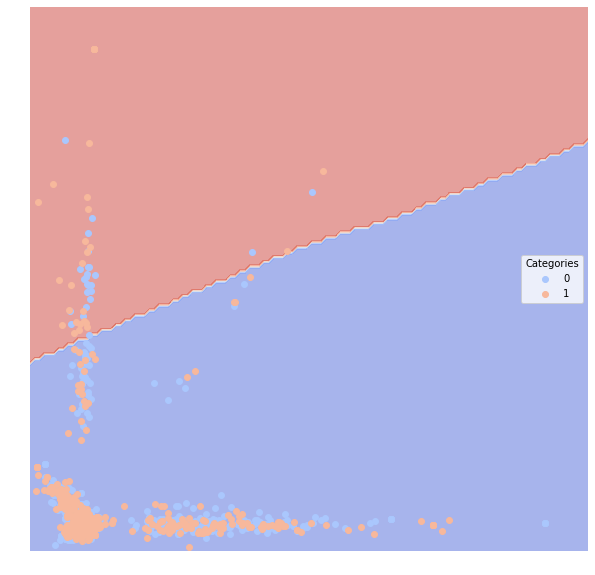

In [191]:
# Plot the PCA space visualization
uncoded_df["category"] = uncoded_df["predict_neural_net"]
lucem_illud_2020.plotregions(clf5, uncoded_df)

#### Comparison of Prediction among Different Classifiers

In [192]:
uncoded_df.sample(10, random_state=25)

,sentence,tokenized,normalized,vect,predict_logistic,category,predict_naive_bayes,predict_decision_tree,predict_random_forest,predict_knearest,predict_svm,predict_neural_net
2009,Have I grown up or am I just not being true to...,"[Have, I, grown, up, or, am, I, just, not, bei...","[grow, true, thirty, grow, realize, right, idea]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,0,0,0
1373,I wanna get away.,"[I, wanna, get, away]","[wanna, away]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,0,0,0,1,1
2293,I was amazed afterwards.,"[I, was, amazed, afterwards]",[amaze],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,1,1,1,1,1,1
1292,"Also, I lied so much in my past until I can't ...","[Also, I, lied, so, much, in, my, past, until,...","[lie, past, lie, anymore]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0,0,0,0,0,1
1110,But it cost me $109!,"[But, it, cost, me, $, 109]","[cost, $]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,0,0,0
1103,"However, I'll be making good money, so it does...","[However, I, 'll, be, making, good, money, so,...","[make, good, money, matt]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,1,1,1,0,1,1
1872,On another shallow shopping note I think after...,"[On, another, shallow, shopping, note, I, thin...","[shallow, shop, note, think, save, $, camera, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,1,0,0,0,0,0
2578,"So eventually she said ""I know you aint talkin...","[So, eventually, she, said, I, know, you, ai, ...","[eventually, say, know, have, not, talk]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0,0,1,1,0,1
1165,I'll feel so much better after Monday.,"[I, 'll, feel, so, much, better, after, Monday]","[feel, well, monday]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0,0,0,0,0,1
2181,My mom was going to be so mad at me.,"[My, mom, was, going, to, be, so, mad, at, me]","[mom, go, mad]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,0,0,0,1,1


### Comments

Unfortunately, neither SVM or neural networks perform similarly with respect to the k-nearest neighbor, naive Bayes, logistic and decision tree approaches with error rates equal to 0.31 and 0.39 respectively, and AUCs 0.65 and 0.62 respectively.